# Разработка A/B-тестирования и анализ результатов

Цель: Для компании, разрабатывающей развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео, необходимо рассчитать параметры A/B-теста, который позволит проверить эту гипотезу о том, что новый алгоритм рекомендаций будет показывать более интересный контент для каждого пользователя.

## Задачи: 
 - рассчитать параметры теста;
 - оценить корректность его проведения;
 - проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных

На самом первом шаге импортируем все необходимые биоблиотеки и функции.

In [1]:
# Импортируем биоблиотеку pandas
import pandas as pd

# Импортируем библиотеку matplotlib.pyplot для визуализации данных
import matplotlib.pyplot as plt

# Импортируем библиотеку numpy для матеметических расчётов
import numpy as np

# Импортируем функцию ceil из библиотеки math для округения в большую сторону
from math import ceil

# Импортируем функцию ttest_ind из модуля scipy.stats
from scipy.stats import ttest_ind


# Импортируем из модуля statsmodels.stats.proportion функцию proportions_ztest
from statsmodels.stats.proportion import proportions_ztest

# Импортируем из модуля statsmodels.stats.power функцию NormalIndPower
from statsmodels.stats.power import NormalIndPower

# Импортируем из модуля sstatsmodels.stats.proportion функцию proportion_effectsize
from statsmodels.stats.proportion import proportion_effectsize

In [2]:
# Создам датафрейм sessions_history, содержащий информацию CSV-файла sessions_project_history.csv
sessions_history=pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')

# Выводим первые пять трок полученного датафрейма
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными

In [3]:
# Рассчитываем количество уникальных сессий для каждого пользователя
sessions_per_user = sessions_history.groupby('user_id', as_index=False)['session_id'].nunique()

# Выделяем пользователя с наибольшим числом сессий
top_user = sessions_per_user.sort_values(by='session_id').tail(1)

# Выделяем id пользователя с наибольшим числом сессий
top_user_id = top_user['user_id']

# Выводим информацию о пользователе с наибольшим числом сессий из таблицы sessions_history
sessions_history.loc[sessions_history['user_id'].isin(top_user_id)]

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
124515,6A73CB5566BB494D,110E3F28C1F5415F,2025-08-28,2025-08-28 18:58:19,2025-08-28,1,0,3,MENA,Mac
196252,6A73CB5566BB494D,D68C8D98A0F1C439,2025-08-29,2025-08-29 20:53:27,2025-08-28,2,1,3,MENA,Mac
242428,6A73CB5566BB494D,6587D217472BF807,2025-08-30,2025-08-30 13:08:22,2025-08-28,3,1,1,MENA,Mac
304287,6A73CB5566BB494D,A9BC25593D056F8E,2025-09-01,2025-09-01 18:52:49,2025-08-28,4,1,2,MENA,Mac
346611,6A73CB5566BB494D,CB6F9C4191FAF6F6,2025-09-03,2025-09-03 22:49:08,2025-08-28,5,1,3,MENA,Mac
363510,6A73CB5566BB494D,9C609432F6E6535A,2025-09-04,2025-09-04 13:59:46,2025-08-28,6,1,4,MENA,Mac
391902,6A73CB5566BB494D,5D892E33B97A257A,2025-09-06,2025-09-06 18:46:55,2025-08-28,7,1,2,MENA,Mac
404322,6A73CB5566BB494D,22A9BD3861F49087,2025-09-07,2025-09-07 18:33:49,2025-08-28,8,1,3,MENA,Mac
415489,6A73CB5566BB494D,F70E351154B092DC,2025-09-08,2025-09-08 20:30:22,2025-08-28,9,1,4,MENA,Mac
425805,6A73CB5566BB494D,84A3DC0CFF449F53,2025-09-09,2025-09-09 16:36:04,2025-08-28,10,1,1,MENA,Mac


Наибольшее количество сессий зафиксировано у пользователя с id 6A73CB5566BB494D.



#### 1.3. Анализ числа регистраций

In [4]:
# Рассчитаем число уникальных пользователей для каждого дня
sessions_history.groupby('session_date',as_index=False)['user_id'].nunique()

,session_date,user_id
0,2025-08-11,3919
1,2025-08-12,6056
2,2025-08-13,8489
3,2025-08-14,10321
4,2025-08-15,14065
5,2025-08-16,12205
6,2025-08-17,11200
7,2025-08-18,10839
8,2025-08-19,12118
9,2025-08-20,13514


In [5]:
# Рассчитаем число зарегистрированных пользователей для каждого дня
sessions_history.groupby('session_date',as_index=False)['registration_flag'].sum()

,session_date,registration_flag
0,2025-08-11,169
1,2025-08-12,336
2,2025-08-13,464
3,2025-08-14,625
4,2025-08-15,840
5,2025-08-16,916
6,2025-08-17,833
7,2025-08-18,860
8,2025-08-19,831
9,2025-08-20,1008


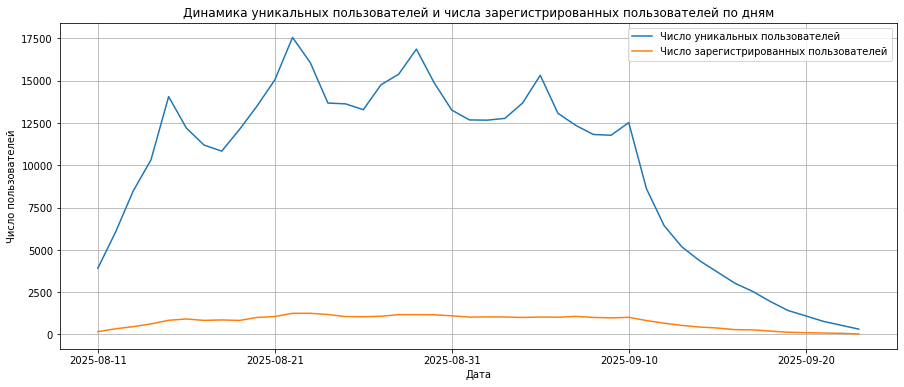

In [6]:
# Зададим размеры графика
plt.figure(figsize=(15, 6))

# Построим график с числом уникальных пользователей и числом зарегистрированных пользователей по дням
sessions_history.groupby('session_date')['user_id'].nunique().plot(kind='line', label='Число уникальных пользователей')
sessions_history.groupby('session_date')['registration_flag'].sum().plot(kind='line',label='Число зарегистрированных пользователей')

# Настраиваем оси
plt.title('Динамика уникальных пользователей и числа зарегистрированных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Число пользователей')
plt.legend(loc='upper right')
plt.grid()
plt.show()

Как видно из графика, в первые дни наблюдения зафиксирован значительный рост числа уникальных пользователей. После чего в динамике показателя наблюдаются перепады с пиковым значением 2025-08-22. Начиная с 2025-09-10 значение показателя резко снижается, и данная тенденция наблюдается вплоть до конца наблюдаемого периода.

Динамика числа регистраций более стабильна относительно динамики количества уникальных пользователей - значительные перепады в значении показателя отсутствуют. Однако как и в случае с уникальными пользователями, начиная с 2025-09-10 наблюдается тенденция к снижению показателя.

In [7]:
# Создадим общий датафрейм с количеством уникальных и зарегистрированных пользователей
users_per_day = sessions_history.groupby('session_date', as_index=False)['user_id'].nunique()
registrations_per_day = sessions_history.groupby('session_date',as_index=False)['registration_flag'].sum()
df_merged = users_per_day.merge(registrations_per_day, on = 'session_date', how = 'right')

# Создадим столбец с долей зарегистрированных пользователей от всех пользователей по дням
df_merged['df_reg_share'] = df_merged['registration_flag'].div(df_merged['user_id'])
df_merged = df_merged.set_index('session_date')
df_merged

,user_id,registration_flag,df_reg_share
session_date,,,
2025-08-11,3919,169,0.043123
2025-08-12,6056,336,0.055482
2025-08-13,8489,464,0.054659
2025-08-14,10321,625,0.060556
2025-08-15,14065,840,0.059723
2025-08-16,12205,916,0.075051
2025-08-17,11200,833,0.074375
2025-08-18,10839,860,0.079343
2025-08-19,12118,831,0.068576


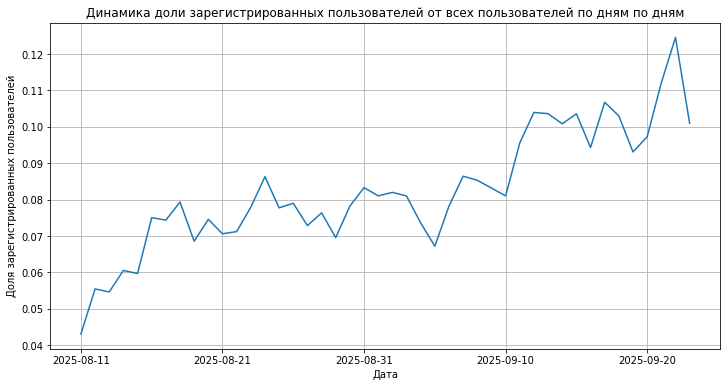

In [8]:
# Зададим размеры графика
plt.figure(figsize=(12, 6))

# Построим график с долей зарегистрированных пользователей от всех пользователей по дням
df_merged['df_reg_share'].plot(kind='line')


# Настраиваем оси
plt.title('Динамика доли зарегистрированных пользователей от всех пользователей по дням по дням')
plt.xlabel('Дата')
plt.ylabel('Доля зарегистрированных пользователей')
plt.grid()
plt.show()

Как видно из графика, несмотря на периодические спады, на протяжении анализируемого периода наблюдается положительная динамика показателя - если в первые дни наблюдения доля зарегистрированных пользователей составляла 0,04, то к концу периода значение увеличилось до отметки 0,10-0,12.

#### 1.4. Анализ числа просмотренных страниц

In [9]:
# Рассчитаем количество сессий для каждого значения количества просмотренных страниц
sessions_per_page_counter=sessions_history.groupby('page_counter')['session_id'].count()
display(sessions_per_page_counter)

page_counter
1     29160
2    105536
3    166690
4    105569
5     26288
6      2589
7        92
Name: session_id, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7')])

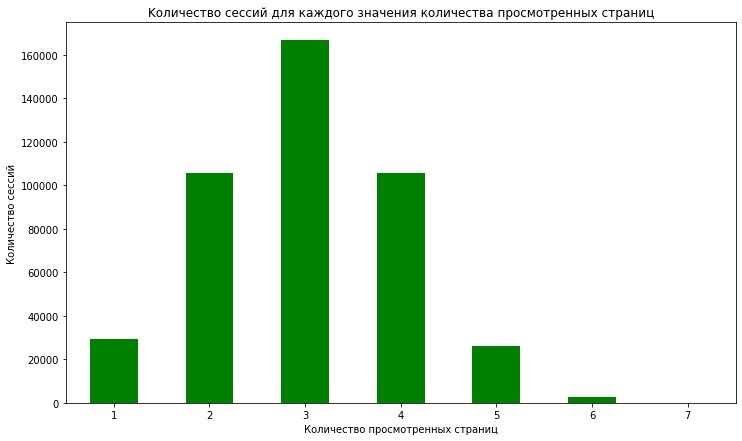

In [10]:
# Построим столбчатую диаграмму с распределением числа просмотров страниц 
sessions_per_page_counter.plot(kind='bar',
               title=f'Kоличество сессий для каждого значения количества просмотренных страниц',
               ylabel='Количество сессий',
               xlabel='Количество просмотренных страниц',
               figsize=(12, 7),
               legend=False,
               color='green')
plt.xticks(rotation=0)


Как видно из диаграммы, в большинстве случаев количество просматриваемых страниц составляет 3. Далее следуют сессии с 2 и 4 просмотренными страницами. Количество сессий с 5 страницами и более значительно ниже количества сессий с число страниц до 4.

#### 1.5. Доля пользователей, просмотревших более четырёх страниц

In [11]:
# Создадим столбец good_session
sessions_history['good_session'] = 0

# Присвоим значение 1, если за одну сессию было просмотрено 4 и более страниц
sessions_history.loc[sessions_history['page_counter']>=4,'good_session']=1

# Выведем измененный датафрейм
sessions_history

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,good_session
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone,0
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android,1
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC,1
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android,1
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android,0
...,...,...,...,...,...,...,...,...,...,...,...
435919,769BC199AF26FEF8,914903B51D69C5EA,2025-09-17,2025-09-17 21:33:57,2025-09-04,3,1,3,CIS,PC,0
435920,599DED39F3CD2ADE,66ADBE343C94DCDA,2025-09-17,2025-09-17 17:11:46,2025-09-04,4,0,4,MENA,iPhone,1
435921,1FA20C4BC94E64B2,C4CCD7E81733665F,2025-09-17,2025-09-17 19:36:55,2025-09-04,4,0,4,CIS,Android,1
435922,88E5FC3016A7A0AD,6834FB4914B56200,2025-09-17,2025-09-17 22:13:33,2025-09-04,5,0,4,MENA,PC,1


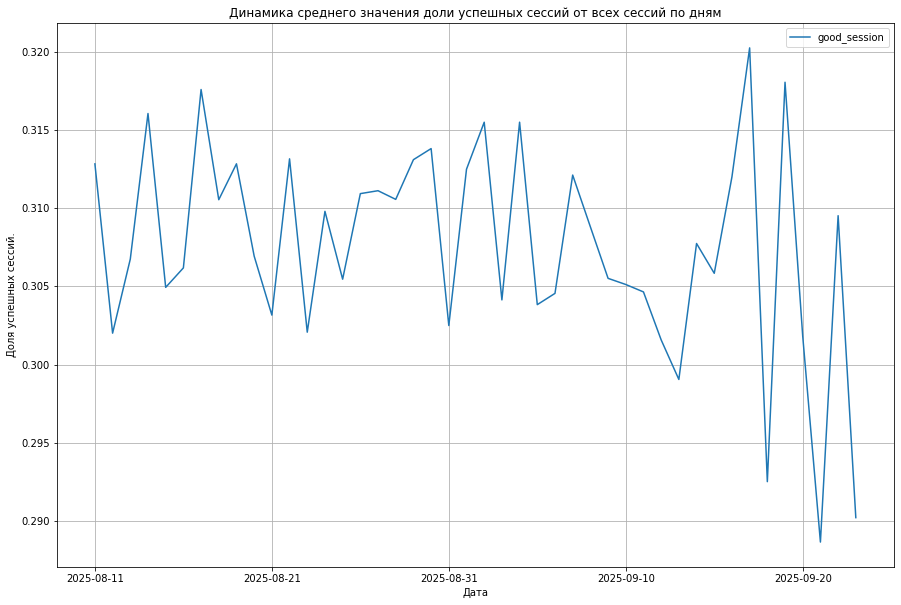

In [12]:
# Построим график со средним значением доли успешных сессий от всех сессий по дням
sessions_history.groupby('session_date')['good_session'].mean().plot(kind='line', figsize=(15, 10))

# Настраиваем оси
plt.title('Динамика среднего значения доли успешных сессий от всех сессий по дням')
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий.')
plt.legend(loc='upper right')
plt.grid()
plt.show()

Из графика видно, что доля успешных сессий от всех сессий по дням на протяжении рассматриваемого периода колеблется от 0,29 до 0,32. При этом в начале рассматриваемого периода наблюдаются незначительные колебания в динамике показателя. Однако, начиная с 2025-09-15 колебания приобретают существенную амплитуду.

### Промежуточный вывод

Таким образом, в данном разделе были проведены загрузка и знакомство с данными. Также был проведён числа уникальных пользователей и числа регистраций по дням. Динамика количества зарегистрированных пользователей имеет относительно стабильную динамику, в то время как количество уникальных пользователей резко увеличивается в начале рассматриваемого периода и значительно снижается по окончанию наблюдения.

Далее был проведён анализ количества просмотренных страниц в ходе сессий пользователей. В большинстве случаев количество просматриваемых страниц составляет 3. Далее следуют сессии с 2 и 4 просмотренными страницами.

Анализ сессий с числом просмотренных страниц 4 и более показал относительно стабильную динамику показателя. Однако в конце рассматриваемого периода колебания стали приобретать более существенную амплитуду.

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Сформулировать нулевую и альтернативную гипотезы

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика рассчитать необходимую длительность проведения теста.

#### 2.1 Формулировка нулевой и альтернативной гипотез

<i>В качестве целевой метрики рассмотрим среднюю долю сессий с количеством просмотренных страниц 4 и более (столбец 'good_session')

H0: Средняя доля сессий с количеством просмотренных страниц 4 и более не изменилась.


H1: Средняя доля сессий с количеством просмотренных страниц 4 и более увеличилась.<i>


#### 2.2. Расчёт размера выборки

In [13]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
p = 0.3 # Базовый уровень доли
mde = 0.03 * p  # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p, p + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


Таким образом, необходимый размер выборки для каждой группы составит 41040, для обеих групп - 41040*2 = 82080. Данного числа наблюдений должно быть достаточно, чтобы обнаружить 3%-ое (mde) изменение целевой метрики между группами при уровне значимости 5% (alpha) с вероятностью 80% (power).

#### 2.3. Расчёт длительности A/B-теста


In [14]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = sessions_history.groupby('session_date')['user_id'].nunique().mean()


# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size*2/avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907.363636363636 пользователей в день составит 9 дней


Таким образом, среднее количество пользователей приложения в день по историческим данным составляет 9907.  Необходимый размер выборки для обеих групп составляет 41040*2 = 82080. В результате рассчитанная длительность A/B-теста при текущем уровне трафика в день составит 82080/9907 =  9 дней.

### Промежуточный вывод

В данном разделе была выбрана целевая метрика, а именно средняя доля сессий с количеством просмотренных страниц 4 и более. Также были сформулированы нулевая и альтернативная гипотезы, в соответствии с которыми средняя доля сессий с количеством просмотренных страниц 4 и более не изменилась и средняя доля сессий с количеством просмотренных страниц 4 и более увеличилась.

Также был определён необходимый размер выборки для каждой группы, который составил 41040 наблюдений. В результате чего, длительность теста, исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения,  должна составить 9 дней.

### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

In [15]:
# Сохраним данные датасета sessions_project_test_part.csv в датафреймsessions_test_part
sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')

# Выведем количество уникальных пользователей в каждой из экспериментальных групп
sessions_test_part.groupby('test_group')['user_id'].nunique()

test_group
A    1477
B    1466
Name: user_id, dtype: int64

In [16]:
# Выведем процентную разницу в количестве пользователей в группах A и B
P=(sessions_test_part[sessions_test_part['test_group']=='A']['user_id'].nunique()-sessions_test_part[sessions_test_part['test_group']=='B']['user_id'].nunique())/sessions_test_part[sessions_test_part['test_group']=='A']['user_id'].nunique()*100
display(f'{P}%')

'0.7447528774542992%'

Процентная разница в количестве пользователей в группах A и B составляет 0,7%.

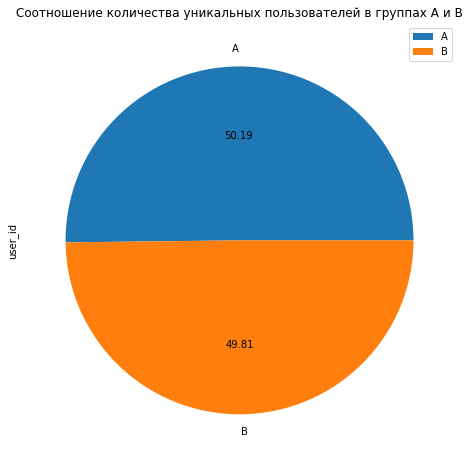

In [17]:
# Построим визуализацию для отображения разницы в количестве пользователей в двух группах
plt.figure(figsize=(10, 8))

sessions_test_part.groupby('test_group')['user_id'].nunique().plot(
               kind='pie', 
               title=f'Соотношение количества уникальных пользователей в группах A и B',
               autopct='%.2f',
               labels=['A', 'B'])

plt.legend()
plt.show()

Из визуализации также наглядно видно, что количество пользователей в обеих группах имеет несущественные различия.

 Таким образом, пользователи разделены правильным образом. Количество пользователей в группе A составляет 1477, в группе B - 1466. разница между группами составляет 0,7%, что не является существенным. 

#### 3.2. Проверка пересечений пользователей

In [18]:
# Выведем id пользователей для обеих групп
Group_A = sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id']
Group_B = sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id']

# Проведём проверку групп на пересечение
intersection = list(set(Group_A) & set(Group_B))
print(intersection) 

[]


Пересечений между группами не обнаружено.

#### 3.3. Равномерность разделения пользователей по устройствам

In [19]:
# Разделим уникальных пользователей для каждой тестовой группы по устройствам
device_for_group_A = sessions_test_part[sessions_test_part['test_group'] == 'A'].groupby('device')['user_id'].nunique()
device_for_group_B = sessions_test_part[sessions_test_part['test_group'] == 'B'].groupby('device')['user_id'].nunique()

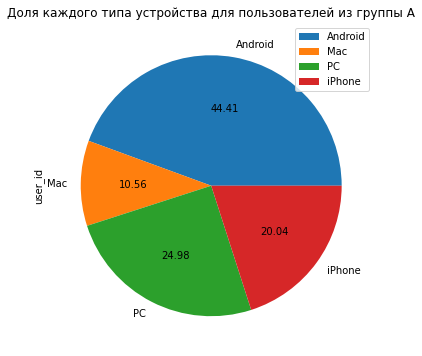

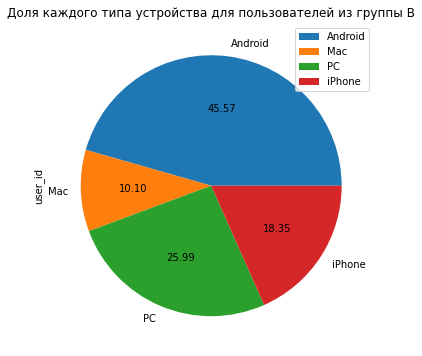

In [20]:
# Построим визуализацию для отображения разницы в доле каждого типа устройства для пользователей из группы A
plt.figure(figsize=(8, 6))

device_for_group_A.plot(
               kind='pie', 
               title=f'Доля каждого типа устройства для пользователей из группы A',
               autopct='%.2f')

plt.legend()
plt.show()

# Построим визуализацию для отображения разницы в доле каждого типа устройства для пользователей из группы B
plt.figure(figsize=(8, 6))

device_for_group_B.plot(
               kind='pie', 
               title=f'Доля каждого типа устройства для пользователей из группы B',
               autopct='%.2f')

plt.legend()
plt.show()

Из визуализации видно, что существенных различий в распределении в группах по типам устройств не наблюдается. Максимальная разница зафиксирована для пользователей, относящихся к категории 'iPhone' - 1,69%.

#### 3.4. Равномерность распределения пользователей по регионам

In [21]:
# Разделим уникальных пользователей для каждой тестовой группы по регионам
region_for_group_A = sessions_test_part[sessions_test_part['test_group'] == 'A'].groupby('region')['user_id'].nunique()
region_for_group_B = sessions_test_part[sessions_test_part['test_group'] == 'B'].groupby('region')['user_id'].nunique()

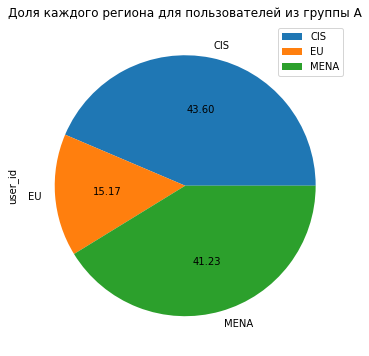

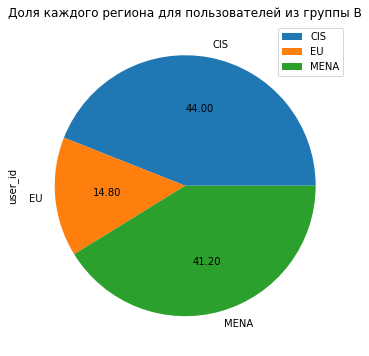

In [22]:
# Построим визуализацию для отображения разницы в доле каждого региона для пользователей из группы A
plt.figure(figsize=(8, 6))

region_for_group_A.plot(
               kind='pie', 
               title=f'Доля каждого региона для пользователей из группы A',
               autopct='%.2f')

plt.legend()
plt.show()

# Построим визуализацию для отображения разницы в доле каждого региона для пользователей из группы B
plt.figure(figsize=(8, 6))

region_for_group_B.plot(
               kind='pie', 
               title=f'Доля каждого региона для пользователей из группы B',
               autopct='%.2f')

plt.legend()
plt.show()

Как и в случае с типами устройств, существенных различий в распределении в группах по регионам не наблюдается. Максимальная разница зафиксирована для пользователей, относящихся к региону 'CIS' - 0,4%.

#### 3.5. Вывод после проверки A/B-теста

В данном разделе был проведён мониторинг А/В-теста. В том числе был проведена проверка распределения пользователей, в ходе которой было установлено, что существенных различий в количестве пользователей в группах не наблюдается, число пользователей в группе A составило 1477 A, в группе B - 1466. Разница между группами составляет 0,7%, что не является существенным. 

Далее была проведена проверка независимости обеих групп, т.е. что никто из пользователей случайно не попал в обе группы одновременно. В результате проверки пересечения пользователей выявлено не было.

Также была проведена проверка равномерного распределения пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам. В ходе проверки существенных различий установлено не было. При проверке распределения по типам устройствам небольшая разница была зафиксирована для пользователей, относящихся к категории 'iPhone' - 1,69%, при проверке распределения по регионам наибольшая разница была зафиксирована для региона 'CIS' - 0,4%.

В результате чего, можно сделать вывод, что A/B-тест проходит корректно,  каких-либо нарушений не наблюдаются: размеры выборок существенно н различаются, пересечений между группами не обнаружено, распределение пользователей по устройствам и регионам между группами соответствует друг другу.

### 4. Проверка результатов A/B-теста

#### 4.1. Получение результатов теста и подсчёт основной метрики

In [23]:
# Сохраним данные датасета sessions_project_test.csv в датафрейм sessions_test
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

In [24]:
# Создадим столбец good_session для датафрейма sessions-test
sessions_test['good_session'] = 0

# Присвоим значение 1, если за одну сессию было просмотрено 4 и более страниц
sessions_test.loc[sessions_test['page_counter']>=4,'good_session']=1

# Выведем измененный датафрейм sessions_test
sessions_test

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0
...,...,...,...,...,...,...,...,...,...,...,...,...
100000,CF77C27B238C1BE3,0F7BC9B33685377C,2025-10-22,2025-10-22 19:01:50,2025-10-20,3,0,3,MENA,Android,A,0
100001,D7ED66C581409AC2,26C4475005E70F47,2025-10-17,2025-10-17 22:12:38,2025-10-17,1,0,5,CIS,PC,A,1
100002,E7EA2D51238020C6,9B9CDE6A612CBD73,2025-10-24,2025-10-24 14:54:07,2025-10-14,2,0,3,MENA,PC,B,0
100003,8A6FEFD7F34C5DA1,37291EC27106EF9D,2025-10-18,2025-10-18 00:05:10,2025-10-14,3,0,4,EU,Android,B,1


#### 4.2. Проверка корректности результатов теста

Создадим датафрейм, содержащий информацию об общем количестве сессий и по группам по дням.

In [25]:
# Рассчитаем количество уникальных сессий для каждого дня
sessions_per_day = sessions_test.groupby('session_date',as_index=False)['session_id'].nunique()

# Рассчитаем количество уникальных сессий для каждого дня и обеих тестовых групп
sessions_per_day_group_A = sessions_test[sessions_test['test_group'] == 'A'].groupby('session_date',as_index=False)['session_id'].nunique()
sessions_per_day_group_B = sessions_test[sessions_test['test_group'] == 'B'].groupby('session_date',as_index=False)['session_id'].nunique()

# Объединим полученные датафреймы
sessions_per_day = sessions_per_day.merge(sessions_per_day_group_A, on='session_date', how='left')
sessions_per_day = sessions_per_day.merge(sessions_per_day_group_B, on='session_date', how='left')

# Переименуем названия столбцов
sessions_per_day = sessions_per_day.rename(columns={'session_id_x': 'total', 'session_id_y': 'A', 'session_id': 'B'})

# Выведем объединённый датафрейм
sessions_per_day

,session_date,total,A,B
0,2025-10-14,3130,1502,1628
1,2025-10-15,4518,2235,2283
2,2025-10-16,6521,3280,3241
3,2025-10-17,8143,4089,4054
4,2025-10-18,10072,5013,5059
5,2025-10-19,13314,6535,6779
6,2025-10-20,11926,5837,6089
7,2025-10-21,7908,3927,3981
8,2025-10-22,6194,3083,3111
9,2025-10-23,5018,2470,2548


In [26]:
# Выведем количество уникальных сессий для каждой группы 
display(sessions_per_day['A'].sum(), sessions_per_day['B'].sum())

# Выведем процентную разницу в количестве пользователей в группах A и B
P=(sessions_per_day['A'].sum()-sessions_per_day['B'].sum())/sessions_per_day['A'].sum()*100
display(P)

49551

50454

-1.8223648362293394

Количество сессий для группа А составило 49 551, для группы В - 50 454. Разница составила 1,8%.

Далее проведём статистический тест, чтобы выявить, является ли различия в двух выборках статистически значимыми. Используем статистический тест, который позволит сделать вывод о равенстве средних двух выборок. Для этого применим двухвыборочный t-тест Стьюдента. В качестве нулевой и альтернативной гипотез зададим:

H0: Средние значения в группах A и B равны.

H1: Средние значения в группах A и B не равны.

Уровень значимости составит 0.05.

In [27]:
# Выборка количества сессий для группы А
sample_a = sessions_per_day['A']
# Выборка количества сессий для группы B
sample_b = sessions_per_day['B']

test_result = ttest_ind(
    sample_a,
    sample_b,
    )

# Фиксируем уровень значимости
alpha = 0.05

if test_result.pvalue > alpha:
    print(f'pvalue={test_result.pvalue} > {alpha}')
    print('Не получилось отвергнуть нулевую гипотезу')
else:
    print(f'pvalue={test_result.pvalue} < {alpha}')
    print('Отвергаем нулевую гипотезу') 

pvalue=0.938219304859116 > 0.05
Не получилось отвергнуть нулевую гипотезу


Поскольку значение p-value превосходит уровень значимости alpha, оснований для отвержения нулевой гипотезы нет. В результате можно сделать вывод о равенстве средних выборок обеих групп.

#### 4.3. Сравнение доли успешных сессий

In [28]:
# Выведем долю успешных сессий для обеих групп
good_sessions_per_group = sessions_test.groupby('test_group',as_index = False)['good_session'].mean()
good_sessions_per_group

,test_group,good_session
0,A,0.307723
1,B,0.318290


In [29]:
# Выведем разницу между долями успешных сессий в абсолютном значении
print('Абсолютная разница в доле успешных сессий между группами:')
print(good_sessions_per_group['good_session'].iloc[0]-good_sessions_per_group['good_session'].iloc[1])

# Выведем разницу между долями успешных сессий в относительном значении
print('Относительная разница в доле успешных сессий между группами:')
print((good_sessions_per_group['good_session'].iloc[0]-good_sessions_per_group['good_session'].iloc[1])/good_sessions_per_group['good_session'].iloc[0]*100)

Абсолютная разница в доле успешных сессий между группами:
-0.010566571724179463
Относительная разница в доле успешных сессий между группами:
-3.4337893199423966


Доля успешных сессий в группе B оказалась выше доли в группе A. Абсолютная разница в доле успешных сессий между группами составила 0.01, относительная разница - 3.4%.

#### 4.4. Насколько статистически значимо изменение ключевой метрики

Перевод проведением статистического теста проведём предварительную проверку корректности данных. Для этого прверим данные на пропуски, дубликаты, пересечение, а также соответствие размера выборки. 

In [30]:
# Выведем общую информацию о датафрейме sessions_test
sessions_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100005 entries, 0 to 100004
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            100005 non-null  object
 1   session_id         100005 non-null  object
 2   session_date       100005 non-null  object
 3   session_start_ts   100005 non-null  object
 4   install_date       100005 non-null  object
 5   session_number     100005 non-null  int64 
 6   registration_flag  100005 non-null  int64 
 7   page_counter       100005 non-null  int64 
 8   region             100005 non-null  object
 9   device             100005 non-null  object
 10  test_group         100005 non-null  object
 11  good_session       100005 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 9.2+ MB


Как видно из выгрузки, пропуски в датафрейме отсутствуют.

Далее проверим данные на дубликаты.

In [31]:
# Проверяем полные дубликаты в датафрейме rest_df
sessions_test.duplicated().sum()

0

Явных дубликатов в датафрейме не обнаружено.

Далее осуществим проверку обеих групп не пересечение.

In [32]:
# Проверим выборки на налиичие пересечений
Group_A = sessions_test[sessions_test['test_group'] == 'A']['session_id']
Group_B = sessions_test[sessions_test['test_group'] == 'B']['session_id']

intersection = list(set(Group_A) & set(Group_B))
print(intersection) 

[]


Пересечений между группами не выявлено.

Расчёт размера выборок был осуществлён в п.п. 4.2. Разница составила 1,8%, что не является существенным.

Поскольку в качестве целевой метрики мы рассматриваем долю сессий, для которых количество просмотренных страниц составляет 4 и более и имеется конкретный признак, по которому осуществляется оценка количества успехов в выборках в качестве статистического теста будет использован Z-тест пропорций.

Для этого необходимо провести оценку достаточности размера каждой из выборок.

In [33]:
# Рассчитаем размер выборки для контрольной группы
n_a = sessions_test[sessions_test['test_group'] == 'A']['session_id'].nunique()

# Рассчитаем размер выборки для тестовой группы
n_b = sessions_test[sessions_test['test_group'] == 'B']['session_id'].nunique()

# Рассчитаем количество для контрольной группы
m_a = m_a = sessions_test[sessions_test['test_group'] == 'A']['good_session'].sum()

# Рассчитаем количество для тестовой группы
m_b = sessions_test[sessions_test['test_group'] == 'B']['good_session'].sum()

# Рассчитаем доли успехов для каждой группы: A и B
p_a, p_b = m_a/n_a, m_b/n_b 

print(f'n_a={n_a}, n_b={n_b}')

print(f'm_a={m_a}, m_b={m_b}')


print(f'p_a={p_a}, p_b={p_b}')


if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

n_a=49551, n_b=50454
m_a=15248, m_b=16059
p_a=0.3077233557344958, p_b=0.31828992745867524
Предпосылка о достаточном количестве данных выполняется!


Таким образом, имеющихся данных достаточно для проведения теста.

In [34]:
# Зададим уровень значимости
alpha = 0.05

stat_ztest, p_value_ztest = proportions_ztest(
    [m_b, m_a],
    [n_b, n_a],
    alternative='larger' 
)
p_value_ztest


if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')

pvalue=0.0001574739988036123 < 0.05
Нулевая гипотеза не находит подтверждения!


Было получено значение p-value, которое очень близко к нулю. Это означает, что нет оснований принимать нулевую гипотезу. Альтернативная гипотеза, согласно результатам статистического теста, находит подтверждение.
Таким образом, можно сделать вывод, что существует статистически значимое различие между долями успешных сессий в группах A и B и в соответствии с альтернативной гипотезой доля сессий с количеством просмотренных страниц 4 и более в группе B выше. 
В результате чего можно сделать вывод, что созданный новый алгоритм рекомендаций показывает более интересный контент для каждого пользователя. 

#### 4.5. Вывод по результатам A/B-эксперимента

В данном разделе был проведён A/B-эксперимент, в соответствие с которым было выдвинуто предположение о том, что созданный новый алгоритм рекомендаций, будет показывать более интересный контент для каждого пользователя и доля успешных сессий с числом просмотренных страниц 4 и более повысится. В качестве целевой метрики взята доля сессий с количеством просмотренных страниц 4 и более (столбец 'good_session'). В качестве нулевой гипотезы было взято предположение о том, что средняя доля сессий с количеством просмотренных страниц 4 и более не изменилась, в качестве альтернативной, что средняя доля сессий с количеством просмотренных страниц 4 и более увеличилась.

Всего данные содержат наблюдения в течение 20 дней эксперимента. Количество сессий для группы А составило 49 551, для группы В - 50 454. Разница составила 1,8%, что не является существенным. Предварительно была проведена проверка данных на корректность (пропуски и дубликаты в данных, пересечение в выборках), в ходе которой нарушений выявлено не было.

Поскольку в качестве целевой метрики рассматривается доля сессий, для которых количество просмотренных страниц составляет 4 и более и имеется конкретный признак, по которому осуществляется оценка количества успехов в выборках, то в качестве статистического теста использовался Z-тест пропорций. Предварительно перед этим была проведена оценка достаточности размера каждой из выборок, в соответствии с которой было выявлено, что имеющихся данных достаточно для проведения статистического теста.

В результате проведения Z-теста пропорций значение составило p-value=0.0001574739988036123, что значительно ниже уровня значимости alpha 0.05, в результате чего оснований принимать нулевую гипотезу выявлено не было и необходимо принять альтернативную гипотезу, о том, что доля успешных сессий выше в тестовой группе B. 

В результате чего можно сделать вывод о том, что новый алгоритм рекомендаций способствует увеличению количества сессий с большим числом просмотренных страниц и по итогам статистического теста можно рекомендовать внедрять нововведение в приложение.